# Preprocessing

In [322]:
import geopandas as gpd
import shapely.geometry
import shapely.wkt
import pandas as pd
import numpy as np
import rasterio
from rasterio.plot import show
import subprocess
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, f1_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', 4)

In [258]:
DATA_FOLDER = 'Data/'
#LAND_COVER = DATA_FOLDER+'LC_1990/DATA/LC_1990.tif'
#SLOPE = DATA_FOLDER+'slope.tif'
#FIRE_YEAR = DATA_FOLDER+'raster_fireyear.tif'
#DEPARTEMENTS = DATA_FOLDER+'Contours/departements-20170102.shp'

## Actual files

LC_CROPPED_90 = DATA_FOLDER+'LC_1990_ND_REC.tif'
LC_CROPPED_00 = DATA_FOLDER+'LC_2000_ND_REC.tif'
LC_CROPPED_06 = DATA_FOLDER+'LC_2006_ND_REC.tif'
LC_CROPPED_12 = DATA_FOLDER+'LC_2012_ND_REC.tif'
LC_CROPPED_18 = DATA_FOLDER+'LC_2018_ND_REC.tif'

FIRES = DATA_FOLDER+'FIREYEAR.tif'
SLOPES_CROPPED = DATA_FOLDER+'SLOPE.tif'
PROTECTED = DATA_FOLDER+'raster_natural_protected.tif'
DEM = DATA_FOLDER+'dem.tif'
ASPECT = DATA_FOLDER+'aspect.tif'
HILLSHADE = DATA_FOLDER+'hillshade.tif'

DISTANCE_18 = DATA_FOLDER+'Distance/URB_DIST_2018.tif'
DISTANCE_12 = DATA_FOLDER+'Distance/URB_DIST_2012.tif'
DISTANCE_06 = DATA_FOLDER+'Distance/URB_DIST_2006.tif'
DISTANCE_00 = DATA_FOLDER+'Distance/URB_DIST_2000.tif'
DISTANCE_90 = DATA_FOLDER+'Distance/URB_DIST_1990.tif'

VEGETATION_2017 = DATA_FOLDER+'Vegetation/vegetation_phenology_2017.pkl'
VEGETATION_2018 = DATA_FOLDER+'Vegetation/vegetation_phenology_2018.pkl'
VEGETATION_2019 = DATA_FOLDER+'Vegetation/vegetation_phenology_2019.pkl'
VEGETATION_2020 = DATA_FOLDER+'Vegetation/vegetation_phenology_2020.pkl'
VEGETATION_2021 = DATA_FOLDER+'Vegetation/vegetation_phenology_2021.pkl'

#### Fires

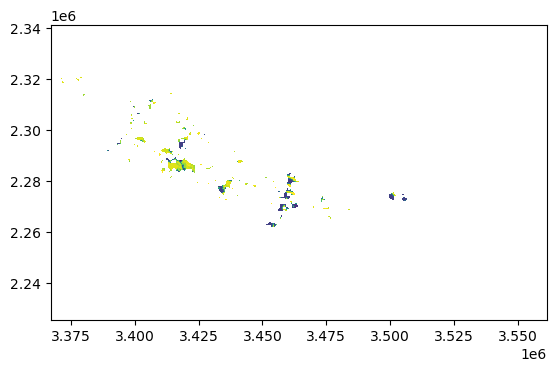

<AxesSubplot:>

In [181]:
fires_raster = rasterio.open(FIRES)
show(fires_raster)

In [182]:
### fires_raster.shape

## Check if the ratserization takes the first one or the last if there is overlaping 
# The rasterization took the last polygone (in the order of the file) when there was an overlapping.
# So we sorted the initial file by the year (ascending), so that after rasterization we get the last fire
# for overlapping polygones.

#### Land covers

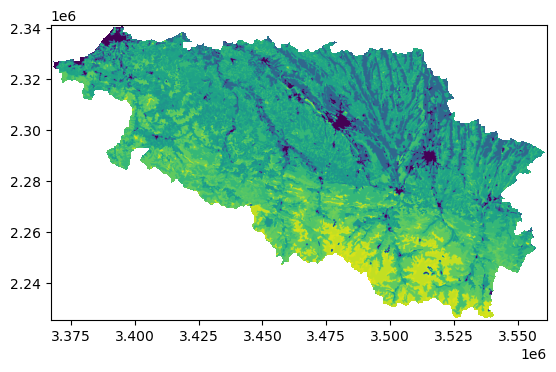

<AxesSubplot:>

In [189]:
lc_90 = rasterio.open(LC_CROPPED_90)
lc_00 = rasterio.open(LC_CROPPED_00)
lc_06 = rasterio.open(LC_CROPPED_06)
lc_12 = rasterio.open(LC_CROPPED_12)
lc_18 = rasterio.open(LC_CROPPED_18)

show(lc_90)

In [196]:
## We processed the files on qgis so that pixels with no data have value 0
## And aggregated the values of the industrial/urban areas into categorie 1
## and areas corresponding to water to categorie 2
lc_cr00

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [194]:
len(lc_cr00[lc_cr00==250])

0

In [75]:
lc_00.shape

(1156, 1943)

#### Slope

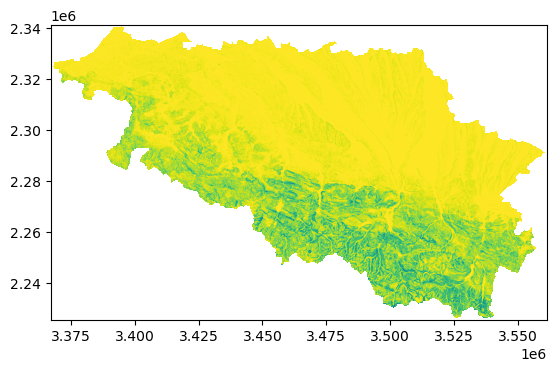

<AxesSubplot:>

In [190]:
slope = rasterio.open(SLOPES_CROPPED)
show(slope)

In [191]:
slope.shape

(1156, 1943)

#### Protected Areas

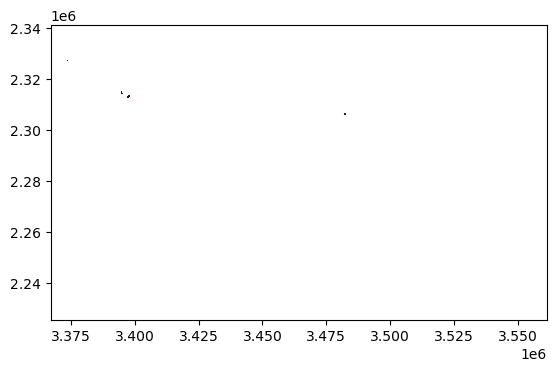

<AxesSubplot:>

In [48]:
protected = rasterio.open(PROTECTED)
show(protected)

In [49]:
protected.shape

(1156, 1943)

#### Digital elevation model

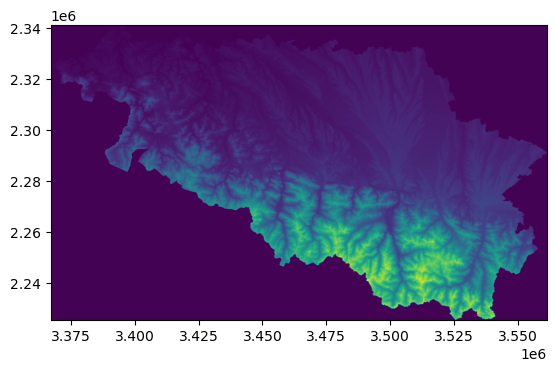

<AxesSubplot:>

In [192]:
dem = rasterio.open(DEM)
show(dem)

In [52]:
dem.shape

(1156, 1943)

In [198]:
len(dem_cr[dem_cr==0])

1026422

In [199]:
len(lc_cr00[lc_cr00==0])

1025846

#### Apsect

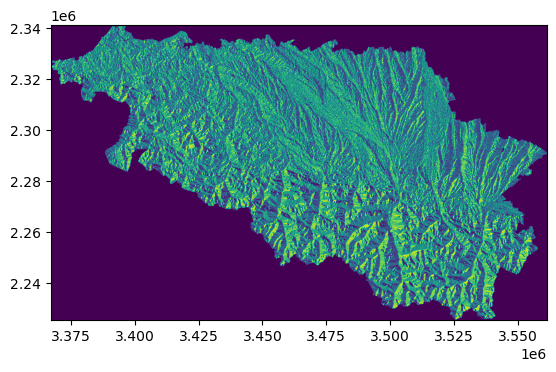

<AxesSubplot:>

In [259]:
aspect = rasterio.open(ASPECT)
show(aspect)

In [260]:
aspect.shape

(1156, 1943)

#### Hillshade

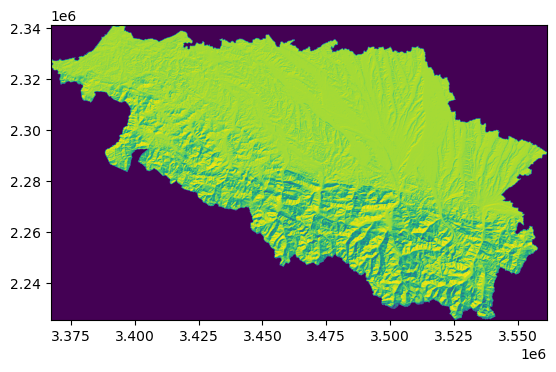

<AxesSubplot:>

In [262]:
hillshade = rasterio.open(HILLSHADE)
show(hillshade)

In [263]:
hillshade.shape

(1156, 1943)

### Creating a Dataframe

In [200]:
lc_cr90 = lc_90.read(1)
lc_cr90 = lc_cr90.flatten()

lc_cr00 = lc_00.read(1)
lc_cr00 = lc_cr00.flatten()

lc_cr06 = lc_06.read(1)
lc_cr06 = lc_cr06.flatten()

lc_cr12 = lc_12.read(1)
lc_cr12 = lc_cr12.flatten()

lc_cr18 = lc_18.read(1)
lc_cr18 = lc_cr18.flatten()

fires_cr = fires_raster.read(1)
fires_cr = fires_cr.flatten()

slopes_cr = slope.read(1)
slopes_cr = slopes_cr.flatten()

dem_cr = dem.read(1)
dem_cr = dem_cr.flatten()

protected_cr = protected.read(1)
protected_cr = protected_cr.flatten()

aspect_cr = aspect.read(1)
aspect_cr = aspect_cr.flatten()

hillshade_cr = hillshade.read(1)
hillshade_cr = hillshade_cr.flatten()

In [267]:
df_data = pd.DataFrame(data=np.c_[lc_cr90, lc_cr00, lc_cr06, lc_cr12, lc_cr18, 
                                  slopes_cr, dem_cr, protected_cr, aspect_cr, hillshade_cr,
                                  fires_cr])
df_data.columns = ['LC90', 'LC00', 'LC06', 'LC12', 'LC18', 'Slope', 'DEM', 
                   'PROTECTED AREAS', 'ASPECT', 'HILLSHADE', 'Fire']
df_data

,LC90,LC00,LC06,LC12,LC18,Slope,DEM,PROTECTED AREAS,ASPECT,HILLSHADE,Fire
0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2246106,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0
2246107,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0


In [268]:
# Function to select the Land cover corresponding to the fire year
def find_year(fire_year, df):
    # Value of fire = 0 corresponds to no fire for the region
    if fire_year==0 : 
        return df['LC18']
    elif fire_year<2000 :
        return df['LC90']
    elif fire_year<2006 :
        return df['LC00']
    elif fire_year<2012 : 
        return df['LC06']
    elif fire_year<2018 :
        return df['LC12']
    else : return df['LC18']

In [269]:
# Selecting the Land cover corresponding to the fire year
df_data['LC'] = df_data.apply(lambda x : find_year(x['Fire'], x), axis=1)

In [271]:
df_data[(df_data['Fire'] != 0) & (df_data['Fire'] < 2006)]

,LC90,LC00,LC06,LC12,LC18,Slope,DEM,PROTECTED AREAS,ASPECT,HILLSHADE,Fire,LC
388683,23.0,23.0,23.0,23.0,23.0,250.0,78.075195,0.0,46.0,217.0,2002.0,23.0
388684,23.0,23.0,23.0,23.0,23.0,249.0,73.623589,0.0,21.0,213.0,2002.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2158073,31.0,31.0,31.0,31.0,31.0,228.0,2886.672607,0.0,243.0,144.0,2005.0,31.0
2158074,31.0,31.0,31.0,31.0,31.0,239.0,2890.255859,0.0,8.0,167.0,2005.0,31.0


In [272]:
df_data['Year'] = df_data.apply(lambda x : 2018 if(x['Fire'] == 0) else x['Fire'], axis=1)

In [273]:
len(df_data[df_data['Year'] < 2016])

15646

In [274]:
len(df_data[df_data['Year'] >= 2018])

2229831

In [275]:
df_data['is_fire'] = df_data.apply(lambda x : 1 if(x['Fire'] != 0) else 0 , axis=1)

In [276]:
df_data[(df_data['Fire'] != 0) & (df_data['Fire'] < 2006)]

,LC90,LC00,LC06,LC12,LC18,Slope,DEM,PROTECTED AREAS,ASPECT,HILLSHADE,Fire,LC,Year,is_fire
388683,23.0,23.0,23.0,23.0,23.0,250.0,78.075195,0.0,46.0,217.0,2002.0,23.0,2002.0,1
388684,23.0,23.0,23.0,23.0,23.0,249.0,73.623589,0.0,21.0,213.0,2002.0,23.0,2002.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2158073,31.0,31.0,31.0,31.0,31.0,228.0,2886.672607,0.0,243.0,144.0,2005.0,31.0,2005.0,1
2158074,31.0,31.0,31.0,31.0,31.0,239.0,2890.255859,0.0,8.0,167.0,2005.0,31.0,2005.0,1


In [277]:
df_data[df_data['is_fire'] == 1]

,LC90,LC00,LC06,LC12,LC18,Slope,DEM,PROTECTED AREAS,ASPECT,HILLSHADE,Fire,LC,Year,is_fire
315112,26.0,27.0,27.0,27.0,27.0,249.0,104.462944,0.0,32.0,208.0,2022.0,27.0,2022.0,1
315113,26.0,27.0,27.0,27.0,27.0,246.0,97.204445,0.0,251.0,197.0,2022.0,27.0,2022.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2158073,31.0,31.0,31.0,31.0,31.0,228.0,2886.672607,0.0,243.0,144.0,2005.0,31.0,2005.0,1
2158074,31.0,31.0,31.0,31.0,31.0,239.0,2890.255859,0.0,8.0,167.0,2005.0,31.0,2005.0,1


In [278]:
len(df_data[df_data['is_fire'] == 0])

2177702

In [279]:
len(df_data[df_data['is_fire'] == 1])

68406

In [280]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2246108 entries, 0 to 2246107
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   LC90             float32
 1   LC00             float32
 2   LC06             float32
 3   LC12             float32
 4   LC18             float32
 5   Slope            float32
 6   DEM              float32
 7   PROTECTED AREAS  float32
 8   ASPECT           float32
 9   HILLSHADE        float32
 10  Fire             float32
 11  LC               float32
 12  Year             float64
 13  is_fire          int64  
dtypes: float32(12), float64(1), int64(1)
memory usage: 137.1 MB


In [281]:
len(df_data[df_data['Fire'] >= 2017])

52564

In [282]:
len(df_data[df_data['Fire'] < 2017])

2193544

In [283]:
df_data

,LC90,LC00,LC06,LC12,LC18,Slope,DEM,PROTECTED AREAS,ASPECT,HILLSHADE,Fire,LC,Year,is_fire
0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,0
1,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2246106,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,0
2246107,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,0


In [286]:
df_final = df_data[['LC', 'Slope', 'DEM', 'PROTECTED AREAS', 'ASPECT', 'HILLSHADE','Year', 'is_fire']]
df_final

,LC,Slope,DEM,PROTECTED AREAS,ASPECT,HILLSHADE,Year,is_fire
0,0.0,255.0,0.0,0.0,0.0,0.0,2018.0,0
1,0.0,255.0,0.0,0.0,0.0,0.0,2018.0,0
...,...,...,...,...,...,...,...,...
2246106,0.0,255.0,0.0,0.0,0.0,0.0,2018.0,0
2246107,0.0,255.0,0.0,0.0,0.0,0.0,2018.0,0


In [287]:
# Filtering out areas with no data

df_final = df_final[(df_final['LC'] != 0) & (df_final['Slope'] != 255) & (df_final['DEM'] != 0.)]
df_final

,LC,Slope,DEM,PROTECTED AREAS,ASPECT,HILLSHADE,Year,is_fire
279,1.0,249.0,11.692942,0.0,25.0,212.0,2018.0,0
280,1.0,249.0,13.497423,0.0,222.0,210.0,2018.0,0
...,...,...,...,...,...,...,...,...
2243808,32.0,221.0,2509.249268,0.0,236.0,111.0,2018.0,0
2243809,32.0,237.0,2535.385254,0.0,235.0,172.0,2018.0,0


### Vegetation 

In [255]:
vegetation_17 = pd.read_pickle(VEGETATION_2017)  
vegetation_18 = pd.read_pickle(VEGETATION_2018)  
vegetation_19 = pd.read_pickle(VEGETATION_2019)  
vegetation_20 = pd.read_pickle(VEGETATION_2020)  
vegetation_21 = pd.read_pickle(VEGETATION_2021)  

In [256]:
vegetation_17

,AMPL_season1_2017,AMPL_season2_2017,MAXV_season1_2017,MAXV_season2_2017,MINV_season1_2017,MINV_season2_2017,QFLAG_season1_2017,QFLAG_season2_2017,LSLOPE_season1_2017,LSLOPE_season2_2017,RSLOPE_season1_2017,RSLOPE_season2_2017
0,-32768.0,-32768.0,-32768.0,-32768,-32768.0,-32768.0,0.0,0.0,-32768.0,-32768.0,-32768.0,-32768.0
1,-32768.0,-32768.0,-32768.0,-32768,-32768.0,-32768.0,0.0,0.0,-32768.0,-32768.0,-32768.0,-32768.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11075262,NaN,NaN,NaN,-32768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11075263,NaN,NaN,NaN,-32768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### In the preprocessing, add features for distance to urban areas and neighboring vegetation !!!

#### Feature engineering the distance to urban areas

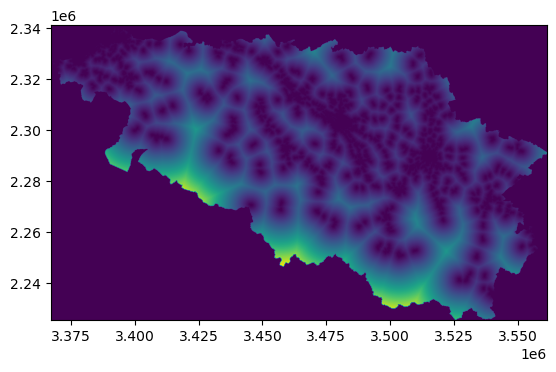

<AxesSubplot:>

In [288]:
lc_90_dist = rasterio.open(DISTANCE_90)
lc_00_dist = rasterio.open(DISTANCE_00)
lc_06_dist = rasterio.open(DISTANCE_06)
lc_12_dist = rasterio.open(DISTANCE_12)
lc_18_dist = rasterio.open(DISTANCE_18)

show(lc_90_dist)

In [289]:
lc_90_dist.shape

(1156, 1943)

In [290]:
distance_90 = lc_90_dist.read(1)
distance_00 = lc_00_dist.read(1)
distance_06 = lc_06_dist.read(1)
distance_12 = lc_12_dist.read(1)
distance_18 = lc_18_dist.read(1)
distance_90

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [291]:
distance_90 = distance_90.flatten()
distance_00 = distance_00.flatten()
distance_06 = distance_06.flatten()
distance_12 = distance_12.flatten()
distance_18 = distance_18.flatten()
distance_90

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [292]:
distances = pd.DataFrame(data=np.c_[distance_90, distance_00, distance_06, distance_12, distance_18],
                        columns = ['Distance90', 'Distance00', 'Distance06', 'Distance12', 'Distance18'])
distances

,Distance90,Distance00,Distance06,Distance12,Distance18
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2246106,0.0,0.0,0.0,0.0,0.0
2246107,0.0,0.0,0.0,0.0,0.0


In [293]:
df_final = df_final.merge(distances, how='left' ,left_index=True, right_index=True)
df_final

,LC,Slope,DEM,PROTECTED AREAS,ASPECT,HILLSHADE,Year,is_fire,Distance90,Distance00,Distance06,Distance12,Distance18
279,1.0,249.0,11.692942,0.0,25.0,212.0,2018.0,0,1.000000,0.000000,0.000000,0.000000,0.000000
280,1.0,249.0,13.497423,0.0,222.0,210.0,2018.0,0,1.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243808,32.0,221.0,2509.249268,0.0,236.0,111.0,2018.0,0,151.743210,151.743210,151.743210,130.506699,151.743210
2243809,32.0,237.0,2535.385254,0.0,235.0,172.0,2018.0,0,151.647614,151.647614,151.647614,129.541504,151.647614


In [294]:
# Function to select the distance of the pixel corresponding to the fire year
def find_distance(fire_year, df):
    # Value of fire = 0 corresponds to no fire for the region
    if fire_year==0 : 
        return df['Distance18']
    elif fire_year<2000 :
        return df['Distance90']
    elif fire_year<2006 :
        return df['Distance00']
    elif fire_year<2012 : 
        return df['Distance06']
    elif fire_year<2018 :
        return df['Distance12']
    else : return df['Distance18']

In [295]:
# Selecting the Land cover corresponding to the fire year
df_final['Distance'] = df_final.apply(lambda x : find_distance(x['Year'], x), axis=1)

In [297]:
df_final.drop(['Distance90', 'Distance00', 'Distance06', 'Distance12', 'Distance18'], 
              axis=1, inplace=True)
df_final

,LC,Slope,DEM,PROTECTED AREAS,ASPECT,HILLSHADE,Year,is_fire,Distance
279,1.0,249.0,11.692942,0.0,25.0,212.0,2018.0,0,0.000000
280,1.0,249.0,13.497423,0.0,222.0,210.0,2018.0,0,0.000000
...,...,...,...,...,...,...,...,...,...
2243808,32.0,221.0,2509.249268,0.0,236.0,111.0,2018.0,0,151.743210
2243809,32.0,237.0,2535.385254,0.0,235.0,172.0,2018.0,0,151.647614


### Random Forest

In [336]:
# We won't split the data by years beacause it does not split as we want it
n = 80

train_df_rf = df_final.iloc[:int(len(df_final)*(n/100))]
test_df_rf = df_final.iloc[int(len(df_final)*(n/100)):]

X_tr = train_df_rf[['LC', 'Slope', 'DEM', 'PROTECTED AREAS', 'ASPECT', 'HILLSHADE', 'Distance']]
Y_tr = train_df_rf['is_fire']

X_te = test_df_rf[['LC', 'Slope', 'DEM', 'PROTECTED AREAS', 'ASPECT', 'HILLSHADE', 'Distance']]
Y_tr = test_df_rf['is_fire']

In [337]:
len(train_df_rf['is_fire'])

974152

### Random Forest

In [339]:
clf = RandomForestClassifier()
clf.fit(X_tr, train_df_rf['is_fire'])
    
y_pred = clf.predict(X_te)
    
precision = precision_score(test_df_rf['is_fire'], y_pred)
f1 = f1_score(test_df_rf['is_fire'], y_pred)

In [340]:
precision

0.11686071582578697

In [341]:
f1

0.15685139632469977

### Logistic Regression

In [335]:
# Standardize the data

scaler = StandardScaler()

df_std = scaler.fit_transform(df_final[['LC', 'Slope', 'DEM', 'PROTECTED AREAS', 'ASPECT', 
                                       'HILLSHADE', 'Distance']])

df_std = pd.DataFrame(data=df_std, columns = ['LC', 'Slope', 'DEM', 
                                              'PROTECTED AREAS', 'ASPECT', 'HILLSHADE', 'Distance'])

df_std

,LC,Slope,DEM,PROTECTED AREAS,ASPECT,HILLSHADE,Distance
0,-2.857382,0.630062,-0.975073,-0.059973,-1.246126,0.247997,-1.013911
1,-2.857382,0.630062,-0.972316,-0.059973,1.263939,0.181076,-1.013911
...,...,...,...,...,...,...,...
1217689,1.732380,-1.085038,2.840619,-0.059973,1.442320,-3.131526,3.564005
1217690,1.732380,-0.104981,2.880548,-0.059973,1.429578,-1.090428,3.561121


In [343]:
# Splitting the data

train_df_lr = df_std.iloc[:int(len(df_final)*(n/100))]
test_df_lr = df_std.iloc[int(len(df_final)*(n/100)):]

X_tr = train_df_lr[['LC', 'Slope', 'DEM', 'PROTECTED AREAS', 'ASPECT', 'HILLSHADE', 'Distance']]

X_te = test_df_lr[['LC', 'Slope', 'DEM', 'PROTECTED AREAS', 'ASPECT', 'HILLSHADE', 'Distance']]

In [344]:
logisticRegr = LogisticRegression()


logisticRegr.fit(X_tr, train_df_rf['is_fire'])

y_pred = logisticRegr.predict(X_te)

precision_lr = precision_score(test_df_rf['is_fire'], y_pred)
f1_lr = f1_score(test_df_rf['is_fire'], y_pred)

In [345]:
precision_lr

0.003152234377897274

In [346]:
f1_lr

0.006022436528242471